In [68]:
import SimpleITK as sitk
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm


import os
import sys
"../scripts" not in sys.path and sys.path.insert(0, '../scripts')

import read_scans_utils

In [69]:
# Function to row-wise normalize a confusion matrix and return a set of labels suitable for plotting
# The labels, for each cell (equal shape to input cm), are the normalized value and the original (integer) count
def normalize_and_create_annotations(cm):
    normalized_cm = normalize(cm, axis = 1, norm = 'l1').round(3)

    labels = np.empty(cm.shape, dtype = object)

    for i, row in enumerate(cm):
        for j, col in enumerate(cm):
            labels[i, j] = f"{normalized_cm[i][j]}\n ({int(cm[i][j])})"

    return normalized_cm, labels

In [70]:
# test_or_val = "validation"
test_or_val = "test"

datafolder = f"../evaluation/contours_compare_{test_or_val}"

root, dirs, files = next(os.walk(f"{datafolder}"))
for i, dir in enumerate(dirs):
    print(f"{i}: {dir}")

0: Dataset001_pca
1: Dataset005_pca
2: Dataset005_pca_simplified
3: Dataset006_pca_gg3gg4combined
4: Dataset007_pca_cribriform_only
5: Dataset008_pcaadc
6: Dataset008_pcaadc_simplified
7: Dataset009_pcaperf


In [77]:
set_number = 1

dataset = dirs[set_number]
dataset_path = f"{datafolder}/{dataset}"

ground_truth_path = f"{datafolder}/{dataset}/ground_truth"
model_output_path = f"{datafolder}/{dataset}/model_output"

# Check if format of ground truth folder & model output folder is consistent
# Both must contain the same amount of files with the same names
# MARPROC[number].nii.gz
all_ids = set(os.listdir(ground_truth_path)) | set(os.listdir(model_output_path))
if len(os.listdir(ground_truth_path)) != len(all_ids) or \
   len(os.listdir(model_output_path)) != len(all_ids):
    print("Files in ground truth and model predictions do not match in filenames")

NUM_PREDICTIONS = len(os.listdir(model_output_path))

In [78]:

cribriform_ground_truths = []
cribriform_predictions = []

# Gleason gradings
gt_gleason_groups = []
mp_gleason_groups = []


for id in tqdm(all_ids):
# for id in all_ids:
    ground_truth = sitk.ReadImage(f"{ground_truth_path}/{id}")
    model_output = sitk.ReadImage(f"{model_output_path}/{id}")

    ground_truth_gleason_group, ground_truth_has_cribriform = read_scans_utils.determine_gleason_grade(ground_truth)
    model_output_gleason_group, model_output_has_cribriform = read_scans_utils.determine_gleason_grade(model_output)

    gt_gleason_groups.append(ground_truth_gleason_group)
    mp_gleason_groups.append(model_output_gleason_group)

    cribriform_ground_truths.append(1 if ground_truth_has_cribriform else 0)
    cribriform_predictions.append(1 if model_output_has_cribriform else 0)
    

# print("The predicted classes:")
# print("Ground truth/actual values: ")
# print(gt_gleason_groups)
# print()
# print("Predicted values:")
# print(mp_gleason_groups)
# print()

# print("Counts: ")
# print(np.unique(gt_gleason_groups, return_counts=True))
# print(np.unique(mp_gleason_groups, return_counts=True))
# print()

print("Cohen kappa score: ")
print(cohen_kappa_score(gt_gleason_groups, mp_gleason_groups, weights = 'quadratic'))
print()
    
cm_gleason_groups = confusion_matrix(gt_gleason_groups,
                                     mp_gleason_groups,
                                     labels = [1, 2, 3, 4])

cm_cribriform = confusion_matrix(cribriform_ground_truths,
                                 cribriform_predictions)



100%|██████████| 53/53 [00:09<00:00,  5.68it/s]

Cohen kappa score: 
0.09430379746835438



In [73]:
print(cm_gleason_groups)

[[ 1  4  2  1]
 [ 2 18  3  0]
 [ 1  8  6  0]
 [ 0  3  4  0]]


Text(0.5, 1.0, 'All-modalities model predicted GGg\nvs ground truth\n')

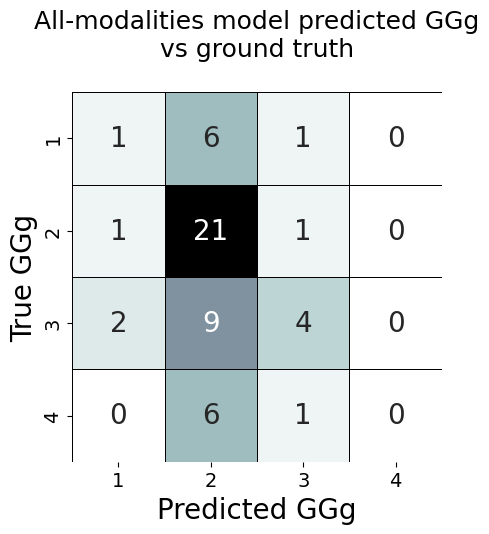

In [79]:
plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

sns.heatmap(cm_gleason_groups,
            xticklabels = [1, 2, 3, 4],
            yticklabels = [1, 2, 3, 4],
            # annot = annotations,
            linewidths = 0.6,
            linecolor = "black",
            annot = True,
            annot_kws = {"size": 20},
            # fmt = '',
            cbar = False,
            square = True,
            cmap = "bone_r")

plt.xlabel("Predicted GGg")
plt.ylabel("True GGg")
plt.title(f"All-modalities model predicted GGg\nvs ground truth\n")
# plt.title(f"T2 & ADC model predicted GGg\nvs ground truth\n")

Text(0.5, 1.0, 'T2 & ADC model predicted presence\nof cribriform vs ground truth\n')

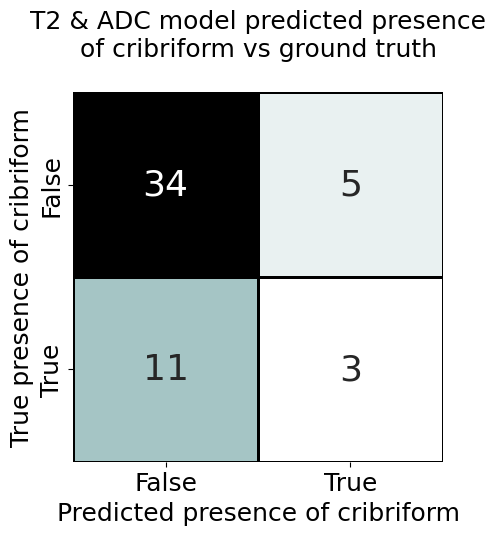

In [ ]:
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title


sns.heatmap(cm_cribriform,
            xticklabels = ["False", "True"],
            yticklabels = ["False", "True"],
            annot = cm_cribriform,
            linewidths = 1,
            linecolor = "black",
            annot_kws = {"size": 26},
            # annot = True,
            # fmt = '',
            cbar = False,
            square = True,
            cmap = "bone_r")

plt.xlabel("Predicted presence of cribriform")
plt.ylabel("True presence of cribriform")
plt.title(f"T2 & ADC model predicted presence\nof cribriform vs ground truth\n")
# plt.title(f"All-modalities model predicted presence\nof cribriform vs ground truth\n")